# Exoplanet Convolutional Neural Network (CNN) Classifier
Here we will use a CNN to classify if a star observed by Kepler contains a exoplanet 

In [1]:
import tensorflow.keras.models
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

First lets load the data and preprocess it.

In [2]:
def load_data(path):
    data = pd.read_csv(path)

    # Convert columns to something more useful.
    for i, column in enumerate(data.columns):
        if 'FLUX' in column:
            data.columns.values[i] = int(column.split('.')[1])
    # Also change labels so 0 is non-exoplanet and 1 is exoplanet
    data.LABEL -= 1
    return data

def normalize_data(df):
    """
    Normalize a Kepler light curve DatFrame with a mean subtraction and 
    """
    # Calculate the mean of each light curve and subtract it
    df_norm = df.copy()
    mean = df_norm.iloc[:, 1:].mean(axis=1)
    df_norm.iloc[:, 1:] = df_norm.iloc[:, 1:].subtract(mean, axis=0)
    # Calculate the standard deviation of each light curve and divide.
    std = df_norm.iloc[:, 1:].std(axis=1)
    df_norm.iloc[:, 1:] = df_norm.iloc[:, 1:].divide(std, axis=0)
    return df_norm


train_data = load_data('./data/exoTrain.csv')
train_data = normalize_data(train_data)

test_data = load_data('./data/exoTest.csv')
test_data = normalize_data(test_data)

Now reshape the arrays to input into the CNN.

In [3]:
train_data_array, train_data_labels = train_data.iloc[:, 1:].values, train_data.iloc[:, 0].values
train_data_array = train_data_array.reshape(*train_data_array.shape, 1)
train_data_labels = train_data_labels.reshape(train_data_labels.shape[0], 1)

test_data_array, test_data_labels = test_data.iloc[:, 1:].values, test_data.iloc[:, 0].values
test_data_array = test_data_array.reshape(*test_data_array.shape, 1)
test_data_labels = test_data_labels.reshape(test_data_labels.shape[0], 1)

print(train_data_array.shape, train_data_labels.shape)
print(test_data_array.shape, test_data_labels.shape)

(5087, 3197, 1) (5087, 1)
(570, 3197, 1) (570, 1)


To ballance the data set we create a batch function to return equal number of exoplanet and non-exoplanet light curves. There will be duplicate light curves.

In [4]:
def light_curve_batch_generator(x, y, batch_size=32):
    """
    Returns equal number of random exoplanets and non-exoplanet detections.
    """
    idx_exo = np.where(y==1)[0]
    idx_nonexo = np.where(y==0)[0]
 
    while True:
        random_idx_exo = np.random.choice(idx_exo, size=batch_size//2, replace=True)
        random_idx_nonexo = np.random.choice(idx_nonexo, size=batch_size//2, replace=True)
        random_idx = np.concatenate((random_idx_exo, random_idx_nonexo))
        np.random.shuffle(random_idx)
        # print(idx, random_idx)
        #print(random_idx)
        train_data = x[random_idx, :, :]
        train_labels = y[random_idx, :]

        for i in range(batch_size):
            random_shift = np.random.randint(train_data.shape[1])
            train_data[i] = np.roll(train_data[i], random_shift, axis=0)
        yield train_data, train_labels

Test the batch generator

In [5]:
# model1 = tensorflow.keras.models.Sequential()
# model1.add(Conv1D(filters=8, kernel_size=100, activation='relu', input_shape=train_data_array.shape[1:]))
# model1.add(MaxPooling1D(strides=4))
# model1.add(Flatten())
# # model1.add(Dense(64, activation='relu'))
# model1.add(Dense(64, activation='relu'))
# model1.add(Dense(1, activation='sigmoid'))

model = tensorflow.keras.models.Sequential()
model.add(Conv1D(filters=8, kernel_size=11, activation='relu', input_shape=train_data_array.shape[1:]))
model.add(MaxPooling1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=11, activation='relu'))
model.add(MaxPooling1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=11, activation='relu'))
model.add(MaxPooling1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model.add(MaxPooling1D(strides=4))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3187, 8)           96        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 797, 8)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 797, 8)            32        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 787, 16)           1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 197, 16)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 197, 16)           64        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 187, 32)           5

In [7]:
model.compile(optimizer=Adam(4e-5), loss='binary_crossentropy', metrics=['accuracy'])

hist = model.fit(x=light_curve_batch_generator(train_data_array, train_data_labels), 
                validation_data=(test_data_array, test_data_labels), 
                verbose=2, epochs=60, steps_per_epoch=train_data_array.shape[0]//32)

Epoch 1/60
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
158/158 - 13s - loss: 0.7341 - accuracy: 0.5214 - val_loss: 0.6896 - val_accuracy: 0.5018
Epoch 2/60
158/158 - 9s - loss: 0.7051 - accuracy: 0.5603 - val_loss: 0.6696 - val_accuracy: 0.5632
Epoch 3/60
158/158 - 9s - loss: 0.6778 - accuracy: 0.6028 - val_loss: 0.6165 - val_accuracy: 0.6737
Epoch 4/60
158/158 - 9s - loss: 0.6593 - accuracy: 0.6123 - val_loss: 0.5856 - val_accuracy: 0.7105
Epoch 5/60
158/158 - 9s - loss: 0.6465 - accuracy: 0.6286 - val_loss: 0.5672 - val_accuracy: 0.7298
Epoch 6/60
158/158 - 9s - loss: 0.6408 - accuracy: 0.6373 - val_loss: 0.5737 - val_accuracy: 0.7175
Epoch 7/60
158/158 - 9s - loss: 0.6197 - accuracy: 0.6620 - val_loss: 0.5468 - val_accuracy: 0.7474
Epoch 8/60
158/158 - 9s - loss: 0.5938 - accuracy: 0.6784 - val_loss: 0.5448 - val_accuracy: 0.7281
Epoch 9/60
158/158 - 9s - loss: 0.5924 - accuracy: 0.6768 - val_loss: 0.5342 - val_accuracy: 0.7456
Epoch

Run with and without batch normalization and look how cleanly the loss decreases.

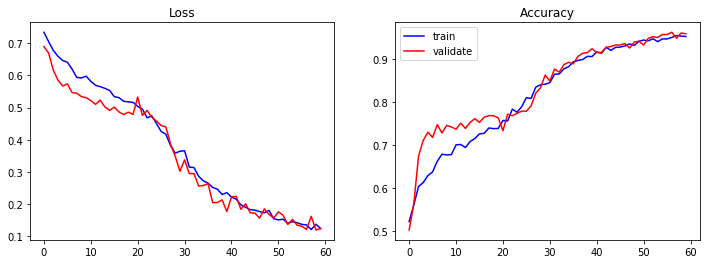

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(hist.history['loss'], color='b')
ax[0].plot(hist.history['val_loss'], color='r')
ax[1].plot(hist.history['accuracy'], color='b', label='train')
ax[1].plot(hist.history['val_accuracy'], color='r', label='validate')
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
ax[1].legend();

In [13]:
model.evaluate(test_data_array, test_data_labels, verbose=2)

570/570 - 0s - loss: 0.1254 - accuracy: 0.9596


[0.12537187276440753, 0.95964915]

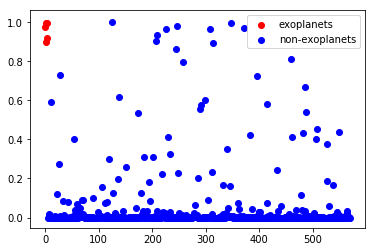

In [15]:
exo_idx = np.where(test_data_labels == 1)[0]
nonexo_idx = np.where(test_data_labels == 0)[0]
cnn_predict = model.predict(test_data_array)

plt.scatter(exo_idx, cnn_predict[exo_idx].flatten(), c='r', label='exoplanets')
plt.scatter(nonexo_idx, cnn_predict[nonexo_idx].flatten(), c='b', label='non-exoplanets')
plt.legend();